In [15]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from Solver import nummodel, nummodel_jac, explicit_solve, implicit_solve
from Utility import interpolate_f2c, gradient_first_f2c
from NeuralNet import *
from timeit import default_timer



# Reference quadratic function
 $$D(\theta) = \theta^2 + (\frac{\partial \theta}{\partial x})^2 + 1$$

In [16]:
def permeability_ref(q, dq):
    return q**2 + dq**2 + 1
def D_permeability_ref(q, dq):
    return 2*q, 2*dq

# Generate Training data

100 max q:  0.04078022799168592  L2 res:  1.6548553347566595
200 max q:  0.05453276471299998  L2 res:  0.5832050054294664
Last step increment is :  0.10139333888070319  last step is :  0.387449937482931
100 max q:  0.08026035177502445  L2 res:  3.1157556094974272
200 max q:  0.10487341575591834  L2 res:  0.948549909014108
Last step increment is :  0.18040494051209352  last step is :  0.7410783413887438
100 max q:  0.11774261449483464  L2 res:  4.30616975724868
200 max q:  0.14963241479766662  L2 res:  1.0810730731764242
Last step increment is :  0.23180469023987993  last step is :  1.0509477118017785
100 max q:  0.1530093879164863  L2 res:  5.217533827022267
200 max q:  0.1889662754769606  L2 res:  1.0512311424338456
Last step increment is :  0.25898359689248496  last step is :  1.3197127065596128
100 max q:  0.18604455850595925  L2 res:  5.865108218346657
200 max q:  0.22352104056969016  L2 res:  0.9337334253769024
Last step increment is :  0.2675109798613518  last step is :  1.553396

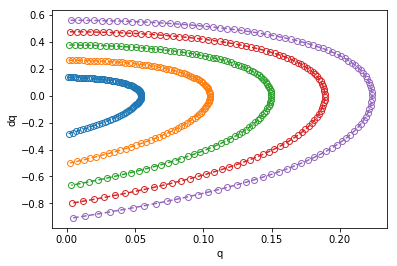

In [17]:
def generate_data_helper(permeability, D_permeability, f_func, L=1.0, Nx = 100):
    xx = np.linspace(0.0, L, Nx)
    dy = xx[1] - xx[0]
    f = f_func(xx)   
    dbc = np.array([0.0, 0.0]) 
    

    model = lambda q, xx, res, V : nummodel_jac(permeability_ref, q, xx, res, V, True, D_permeability_ref)  
    xx, t_data, q_data = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
    print("Last step increment is : ", np.linalg.norm(q_data[-1, :] - q_data[-2, :]), " last step is : ", np.linalg.norm(q_data[-1, :]))
    
    q = q_data[-1, :]
    q_c, dq_c = interpolate_f2c(q), gradient_first_f2c(q, dy)
    return xx, f, q, q_c, dq_c 


f_funcs = []
n_data = 5

for i in range(1,6):
    def func(xx, A = i):
        return A * xx
    f_funcs.append(func)
    
    
L = 1.0
Nx = 100
n_data = len(f_funcs)
xx, f, q, q_c, dq_c = np.zeros((n_data, Nx)), np.zeros((n_data, Nx)), np.zeros((n_data, Nx)), np.zeros((n_data, Nx-1)), np.zeros((n_data, Nx-1))


for i in range(n_data):
    xx[i, :], f[i, :], q[i, :], q_c[i, :], dq_c[i, :] = generate_data_helper(permeability_ref, D_permeability_ref, f_funcs[i], L=L, Nx=Nx)
    

# visualize data



plt.figure()
for i in range(n_data):
    plt.plot(q_c[i, :], dq_c[i, :],  "--o", fillstyle="none")

plt.xlabel("q")
plt.ylabel("dq")
plt.show()

In [18]:
def creat_nn_model(input_dim, hidden_dim, output_dim, params):
    net = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden_dim),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_dim, output_dim),
#             torch.nn.Sigmoid()
    )

    weights1 = params[:hidden_dim*input_dim].reshape(hidden_dim,input_dim)
    weights1 = torch.nn.parameter.Parameter(torch.tensor(weights1, dtype=torch.float32))
    bias1 = params[hidden_dim*input_dim:hidden_dim*(input_dim+1)].reshape(1,hidden_dim)
    bias1 = torch.nn.parameter.Parameter(torch.tensor(bias1, dtype=torch.float32))
    weights2 = params[hidden_dim*(input_dim+1):hidden_dim*(input_dim+1+output_dim)].reshape(output_dim,hidden_dim)
    weights2 = torch.nn.parameter.Parameter(torch.tensor(weights2, dtype=torch.float32))
    bias2 = params[hidden_dim*(input_dim+1+output_dim):hidden_dim*(input_dim+1+output_dim)+output_dim].reshape(1,output_dim)
    bias2 = torch.nn.parameter.Parameter(torch.tensor(bias2, dtype=torch.float32))

    net[0].weight = weights1
    net[0].bias = bias1
    net[2].weight = weights2
    net[2].bias = bias2
    return net

def nn_model(x, input_dim, hidden_dim, output_dim, params):
    net = creat_nn_model(input_dim, hidden_dim, output_dim, params)
    return net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()


In [19]:
input_dim, hidden_dim, output_dim = 2, 10, 1

net = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden_dim),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_dim, output_dim),
#             torch.nn.Sigmoid()
    )

print(net)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


# Training Loss : || d(D dq/dy)/dy + f(x)|| on the quadratic function

In [20]:
def loss(s_param, params):
    xx, q = s_param.xx, s_param.q
    input_dim, hidden_dim, output_dim = s_param.input_dim, s_param.hidden_dim, s_param.output_dim
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    
    def permeability(q, dq):
        x = np.vstack((q, dq)).T
        permeability = nn_model(x, input_dim, hidden_dim, output_dim, params)
        # permeability = nn_model(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
        return permeability

    
    for i in range(N_data):
        nummodel(permeability, q[i, :], xx[i, :], res[i, :])
        
    return np.hstack((-np.reshape(res, -1), params))
    

## Start UKI

In [21]:
from KalmanInversion import UKI, UKI_Run
class PoissonParam:
    def __init__(self, xx, q, N_y, input_dim, hidden_dim, output_dim):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        N_theta = input_dim*hidden_dim + hidden_dim + hidden_dim*output_dim + output_dim
        self.N_theta = N_theta
        self.N_y = N_y + N_theta

In [22]:

y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(n_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.05)**2, -1))


N_y = len(y)
input_dim, hidden_dim, output_dim = 2, 20, 1
s_param = PoissonParam(xx, q, N_y,  input_dim, hidden_dim, output_dim)


N_theta = s_param.N_theta

theta0_mean = np.zeros(N_theta)
theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 1.0**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)
print(theta0_cov.shape, Sigma_eta.shape)

alpha_reg = 1.0
update_freq = 1
N_iter = 30
uki_obj = UKI_Run(s_param, loss, 
    theta0_mean, theta0_cov,
    y_aug, Sigma_eta_aug,
    alpha_reg,
    update_freq,
    N_iter)

# uki_errors    = np.zeros((N_iter+1, 2))

# for i in range(N_iter+1):

#     uki_errors[i, 0] = np.linalg.norm(uki_obj.theta_mean[i] - theta_post)/np.linalg.norm(theta_post)
#     uki_errors[i, 1] = np.linalg.norm(uki_obj.theta_cov[i] - Sigma_post)/np.linalg.norm(Sigma_post)

# import  matplotlib.pyplot as plt
# ites = np.arange(0, N_iter+1)    
# fig, ax = plt.subplots(nrows = 1, ncols=2, sharex=False, sharey=False, figsize=(15,6))
# ax[0].semilogy(ites, uki_errors[:, 0],   "-.x", color = "C0", fillstyle="none", label="UKI")
# ax[0].set_xlabel("Iterations")
# ax[0].set_ylabel("Rel. mean error")
# ax[0].grid("on")
# ax[1].semilogy(ites, uki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="UKI")
# ax[1].set_xlabel("Iterations")
# ax[1].set_ylabel("Rel. covariance error")
# ax[1].grid("on")
# ax[1].legend(bbox_to_anchor=(1.0, 1.0))
# fig.tight_layout()
# plt.show()

(81, 81) (490, 490)
optimization error at iter  0  =  130006.734006734
Frobenius norm of the covariance at iter  0  =  9.0
optimization error at iter  1  =  8573.367550216333
Frobenius norm of the covariance at iter  1  =  8.944271909999506
optimization error at iter  2  =  3096.85863446636
Frobenius norm of the covariance at iter  2  =  8.775245382790324
optimization error at iter  3  =  7400.242754699035
Frobenius norm of the covariance at iter  3  =  8.6065907121889
optimization error at iter  4  =  44850.2802503171
Frobenius norm of the covariance at iter  4  =  8.160447768149437
optimization error at iter  5  =  1569.688046088799
Frobenius norm of the covariance at iter  5  =  7.579402242037393
optimization error at iter  6  =  4726.041930932743
Frobenius norm of the covariance at iter  6  =  7.357493100995596
optimization error at iter  7  =  2396.7340303944793
Frobenius norm of the covariance at iter  7  =  7.276536886908458
optimization error at iter  8  =  3773.68054416596
Fro

In [23]:
nn_model = creat_nn_model(input_dim, hidden_dim, output_dim, uki_obj.theta_mean[-1])

# Direct test

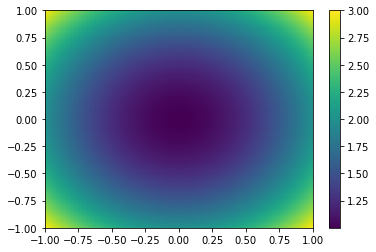

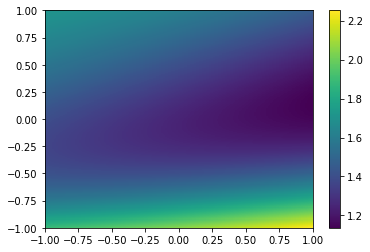

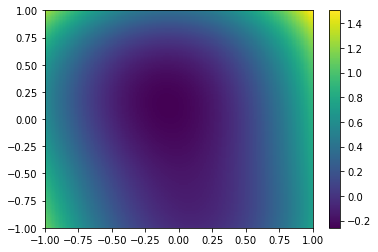

In [24]:
N_test_1d = 200
L_test_1d = 1.0
N_test = N_test_1d**2

x_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x_test_1d, x_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = permeability_ref(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))



x_test = torch.from_numpy(x_test.astype(np.float32))
y_pred = nn_model(x_test).detach().numpy()

y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
plt.colorbar()


# Plug-in test

100000 max q 0.20496633196903816
200000 max q 0.2452163765409305
100000 max q 0.1969854081737204
200000 max q 0.23874389375144275


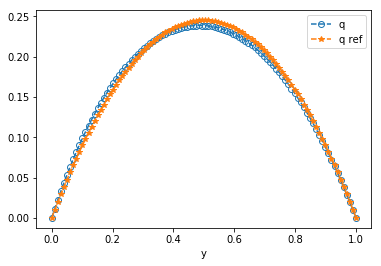

In [25]:
def permeability(q, dq):
    
    x = np.vstack((q, dq)).T
    
    permeability = nn_model(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
    
    return permeability

def D_permeability(q, dq):
    
    Nx = q.size
    Dq, Ddq = np.zeros(Nx), np.zeros(Nx)
    
    for i in range(Nx):
        x = torch.from_numpy(np.array([[q[i],dq[i]]]).astype(np.float32))
        x.requires_grad = True
        y = nn_model(x)  #.detach().numpy().flatten()
        d = torch.autograd.grad(y, x)[0].numpy().flatten()
        Dq[i], Ddq[i] = d[0], d[1]
    
    
    return Dq, Ddq

L = 1.0
Nx = 100
xx = np.linspace(0.0, L, Nx)
f = 6*(1-2*xx)**2 - 2*(xx - xx**2)*(1 - 2*xx)**2 + 2*(xx - xx**2)**2 + 2 
q_sol = -xx*(xx - 1)
dbc = np.array([0.0, 0.0]) 

MODEL = "exp_nummodel"

if MODEL == "exp_nummodel":
    
    model = lambda q, xx, res : nummodel(permeability_ref, q, xx, res)
    xx, t_data_ref, q_data_ref = explicit_solve(model, f, dbc, dt = 1.0e-6, Nt = 200000, save_every = 100000, L = L)

    model = lambda q, xx, res : nummodel(permeability, q, xx, res)
    xx, t_data, q_data = explicit_solve(model, f, dbc, dt = 1.0e-6, Nt = 200000, save_every = 100000, L = L)

elif MODEL == "imp_nummodel":
    
    model = lambda q, xx, res, V : nummodel_jac(permeability_ref, q, xx, res, V, True, D_permeability_ref)  
    xx_ref, t_data_ref, q_data_ref = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
    model = lambda q, xx, res, V : nummodel_jac(permeability, q, xx, res, V, True, D_permeability)  
    xx, t_data, q_data = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
elif MODEL == "imp_Newton_nummodel":
    
    model = lambda q, xx, res, V : nummodel_jac(permeability_ref, q, xx, res, V, True, D_permeability_ref)  
    xx_ref, t_data_ref, q_data_ref = implicit_Newton_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
    model = lambda q, xx, res, V : nummodel_jac(permeability, q, xx, res, V, True, D_permeability)  
    xx, t_data, q_data = implicit_Newton_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
else:
    print("ERROR")


plt.figure()
plt.plot(xx, q_data[-1, :],  "--o", fillstyle="none", label="q")
plt.plot(xx, q_data_ref[-1, :],  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()